In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize

# Visual Preference
%matplotlib inline
warnings.filterwarnings(action='ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged', con=engine)
engine.dispose()
weather_df.head()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


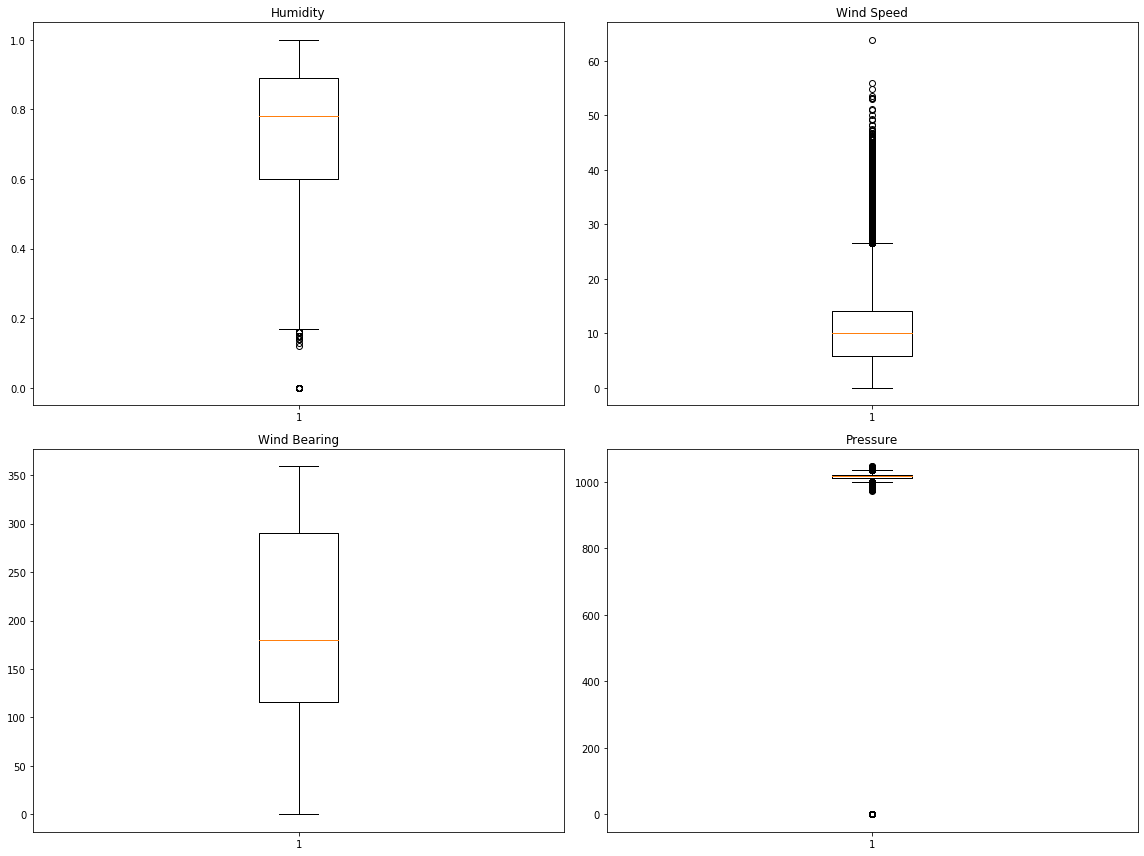

In [3]:
# Clean the data
# What sort of cleaning is required??
# Visualize Explanatory Variables

plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.boxplot(weather_df['humidity'])
plt.title('Humidity')

plt.subplot(2,2,2)
plt.boxplot(weather_df['windspeed'])
plt.title('Wind Speed')

plt.subplot(2,2,3)
plt.boxplot(weather_df['windbearing'])
plt.title('Wind Bearing')

plt.subplot(2,2,4)
plt.boxplot(weather_df['pressure'])
plt.title('Pressure')

plt.tight_layout()
plt.show()

In [4]:
# Limit the outliers and drop non-numerical
weather_df = weather_df.select_dtypes(exclude=['datetime64[ns, UTC]'])
weather_df = weather_df.select_dtypes(exclude=['object'])

weather_df['w_humidity'] = winsorize(weather_df['humidity'], (0,0.10))
weather_df['w_windspeed'] = winsorize(weather_df['windspeed'], (0,0.10))
weather_df['w_pressure'] = winsorize(weather_df['pressure'], (0,0.10))

[35.33 56.25 75.39 85.43 93.09 99.51 99.94 99.99]


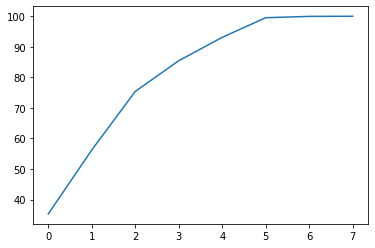

In [5]:
# Drop null values and standardize the data
weather_df = weather_df.dropna()
X_weather = scale(weather_df)

# Determine the number of components
pca = PCA(n_components=8)
pca.fit(X_weather)

var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)
plt.plot(var1)
plt.show()

In [7]:
# Apply PCA and create the model
sklearn_pca = PCA(n_components=8)
X = sklearn_pca.fit_transform(X_weather)
Y = weather_df['temperature']
lrm_weather = linear_model.LinearRegression()
lrm_weather.fit(X,Y)
print('Coefficients: ', lrm_weather.coef_)
print('Intercept: ', lrm_weather.intercept_)

Coefficients:  [ 4.40622572 -1.31812932  1.59217406 -0.78322801  0.22553255 -4.54592824
 -0.06982166 -6.79609226]
Intercept:  11.932678437511882


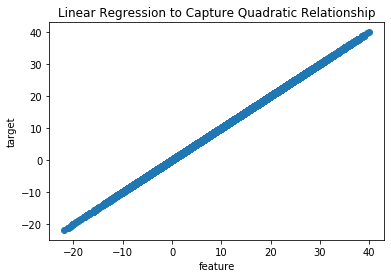

In [8]:
# Determine linearity of the model
w_pred = lrm_weather.predict(X)

# Plot estimated Y and X which should have a quadratic relationship
plt.scatter(Y, w_pred)
plt.xlabel('feature')
plt.ylabel('target')
plt.title('Linear Regression to Capture Quadratic Relationship')
plt.show()

In [9]:
# Determine the average error term
errors = Y - w_pred
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -2.566790327574017e-15


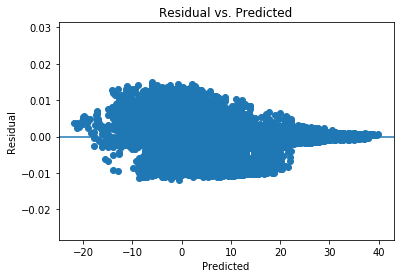

In [10]:
# Visualization of homoscedasticity
plt.scatter(w_pred, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [22]:
# Statistical test of homoscedasticity
from scipy.stats import bartlett, levene, boxcox
from sklearn.preprocessing import normalize

b_stats = bartlett(w_pred, errors)
l_stats = levene(w_pred, errors)

print('Bartlett test statistic value is {0:3g} and p-value is {1:.3g}'.format(b_stats[0], b_stats[1]))
print('Levene test statistic value is {0:3g} and p-value is {1:.3g}'.format(l_stats[0], l_stats[1]))

# Errors are heteroscedastic (How do we fix this?)

Bartlett test statistic value is 1.45941e+06 and p-value is 0
Levene test statistic value is 211415 and p-value is 0


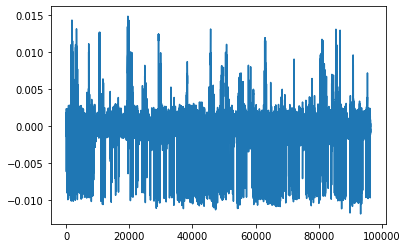

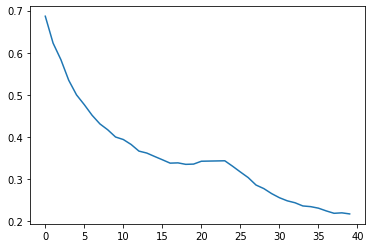

In [24]:
# Check correlation of error terms - visualization
plt.plot(errors)
plt.show()

# Check correlation of error terms - statistical test
from statsmodels.tsa.stattools import acf
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()

# What labels does this need?

In [25]:
# Check for feature correlation with errors
from scipy.stats import jarque_bera, normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 277545.79040257557 and p value is 0.0
Normality test statistics is 21424.59569674525 and p value is 0.0
